In [1]:
import torch
import torch.nn as nn
# import torchsummary
import torchmetrics
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
plt.rcParams['text.usetex'] = True

import os
from h5 import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time
from sklearn.model_selection import train_test_split

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
from triqs.operators import *
from triqs.gf import *
from triqs.gf.descriptors import MatsubaraToLegendre

from triqs_tprf.ParameterCollection import ParameterCollection
from triqs_tprf.ParameterCollection import ParameterCollections


In [3]:
def load_db(filename):
    n_entries = 0
    params = 0
    smpls_list = 0
    data2train = []
    with HDFArchive(filename, 'r') as ar:
        n_entries = ar['n_entries']
        params = ar["params"] 
        smpls_list = ar["samples"] 
        # a = smpls_list[0]['pc']
        # print(a.iter)
        # print(params)
        for smpl_id, sample in enumerate(smpls_list):
            ps = sample['pc']
            prms = params[smpl_id]
            dt2train = []
            for p in ps:
                dt2train.append(
                    [ 
                        [p.time2solve, p.averageorder],
                        [prms['U'], prms['beta'], p.g0_l.data.flatten()[:30]],
                        [ p.g_l.data.flatten()[:30]]
                    ]
                )
            data2train.extend(dt2train)
    return data2train

# db_names = [
#     'database_v4.h5',
#     'database_v5.h5',
#     'database_v6.h5'
#             ]
db_names = ['./data/databaseV14.h5',
            './data/databaseV15.h5',
            './data/databaseV16.h5',
            './data/databaseV17.h5']
data_list = [load_db(db_name) for db_name in db_names]
data = []
for dataq in data_list:
    data.extend(dataq)
print(len(data))

1105


In [12]:
# def load_db(filename):
#     n_entries = 0
#     params = 0
#     smpls_list = 0
#     with HDFArchive(filename, 'r') as ar:
#         n_entries = ar['n_entries']
#         params = ar["params"] 
#         smpls_list = ar["samples"] 
#     # print(params)
#     data2train = [ [[sample['time2solve'], sample['averageorder']],
#                     [params[smpl_id]['U'], params[smpl_id]['beta'], 
#                       np.real(sample['G0_l'].data).flatten()[:30]], 
#                     [ np.real(sample['G_l'].data).flatten()]]  
#                   for smpl_id, sample in enumerate(smpls_list)] 
#     return data2train

# # db_names = [
# #     'database_v4.h5',
# #     'database_v5.h5',
# #     'database_v6.h5'
# #             ]
# db_names = ['./data/databaseV8.h5',
#             './data/databaseV9.h5',
#             './data/databaseV10.h5',
#             './data/databaseV11.h5']
# data_list = [load_db(db_name) for db_name in db_names]
# data = []
# for dataq in data_list:
#     data.extend(dataq)
# print(len(data))

In [4]:
U       = np.array([sample[1][0] for sample in data])
beta    = np.array([sample[1][1] for sample in data])
times   = np.array([sample[0][0] for sample in data])
order   = np.array([sample[0][1] for sample in data])

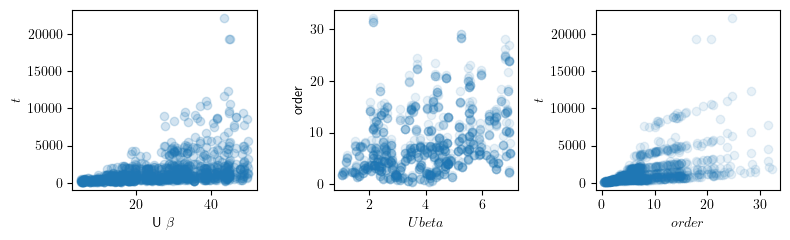

In [5]:
fig, (ax, bx, cx) = plt.subplots(  1, 3, figsize=( 8, 2.5), dpi=100)

ax.scatter(beta, times, alpha=0.2)
ax.set_xlabel(r'U $\beta$')
ax.set_ylabel(r'$t$')

# bx.scatter(U, time)
bx.scatter(U, order, alpha=0.1)
bx.set_xlabel(r'$U beta$')
bx.set_ylabel('order')

cx.scatter(order, times, alpha=0.1)
cx.set_xlabel(r'$order$')
cx.set_ylabel(r'$t$')


fig.tight_layout()
plt.show()


In [6]:
def make_training_Data(db):
    X = np.array([np.hstack(sample[1]) for sample in db])
    Y = np.array([sample[2][0] for sample in db])
    params = np.array([sample[0] for sample in db])
    return X, Y, params

features, targets, params = make_training_Data(data)
print(f'in total {len(features)} rows \n\n')
print(f'num features {len(features[0])}')
print(f'num targets {len(targets[0])}')
print(f'num params {len(params[0])}\n\n')

X_train, X_test, y_train, y_test, params_train, params_test = \
    train_test_split(features, targets, params, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test, params_val, params_test = \
    train_test_split(X_test, y_test, params_test, test_size=0.33, random_state=42)


print(f'num train {len(X_train)}')
print(f'num val {len(X_val)}')
print(f'num test {len(X_test)}')


in total 1105 rows 


num features 32
num targets 30
num params 2


num train 773
num val 222
num test 110


In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_size=32, output_size=30):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            # Your network structure comes here
            nn.Linear(input_size, 64),  # First hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(64, 128),           # Second hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(128, 64),           # Third hidden layer
            nn.ReLU(),                    # Activation function
            nn.Linear(64, output_size)    # Output layer
        )    
        #     nn.Linear(784, 32),
        #     nn.BatchNorm1d(32),
        #     nn.ELU(),
        #     nn.Linear(32,10),
        #     nn.Linear(input_shape, num_classes)
        # )
        
    def forward(self, inp):       
        out = self.model(inp)
        # print(out)
        return out
    
# torchsummary.summary(TinyNeuralNetwork().to(device), (500, 42))


In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y, params = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield torch.Tensor(X[batch_idx]), torch.Tensor(Y[batch_idx]), params[batch_idx]


# batch_size = 4
# train_loader = get_batches((X_train, y_train), batch_size)
# test_loader = get_batches((X_test, y_test), batch_size)

# batch_size = 128
# for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
#     print(x_batch.shape)
    

In [9]:
def train_model(model, batch_size, loss_func, opt, acc, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch, _ in get_batches((X_train, y_train, params_train), batch_size):
            # print(X_batch.shape)
            
            X_batch = X_batch.to(device, torch.float32)
            y_batch = y_batch.to(device, torch.float32)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            
            # print(X_batch)
            y_pred = model(X_batch)
            # print(y_pred)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())

        
        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch, _ in get_batches((X_val, y_val, params_val), batch_size):
                # move data to target device
                
                X_batch = X_batch.to(device, torch.float32)
                y_batch = y_batch.to(device, torch.float32)
                # compute predictions
                
                y_pred = model(X_batch)
                ep_val_loss.append( loss_func(y_pred, y_batch) )
                ep_val_accuracy.append( acc(y_pred, y_batch))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy


def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)


In [10]:
model = TinyNeuralNetwork().to(device, torch.float32)
opt =  torch.optim.Adam(model.parameters(), lr=1e-3) 
loss_func = nn.MSELoss()
acc = torchmetrics.MeanSquaredError()

In [11]:
load_checkpoint(checkpoint_path='./models/model_v4', model=model, optimizer=opt)

model loaded from ./models/model_v4


In [12]:
n_epochs = 200
batch_size = 128
train_loss, test_loss, val_accuracy = train_model(model, batch_size, loss_func, opt, acc, n_epochs)

/tmp/ipykernel_823184/3461640320.py:15: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/Copy.cpp:305.)
  yield torch.Tensor(X[batch_idx]), torch.Tensor(Y[batch_idx]), params[batch_idx]


Epoch 1 of 200 took 0.054s
	  training loss: 0.010553
	validation loss: 0.007093
	validation accuracy: 0.007
Epoch 2 of 200 took 0.014s
	  training loss: 0.005282
	validation loss: 0.003722
	validation accuracy: 0.004
Epoch 3 of 200 took 0.013s
	  training loss: 0.002883
	validation loss: 0.003624
	validation accuracy: 0.004
Epoch 4 of 200 took 0.012s
	  training loss: 0.002406
	validation loss: 0.002292
	validation accuracy: 0.002
Epoch 5 of 200 took 0.012s
	  training loss: 0.001645
	validation loss: 0.001181
	validation accuracy: 0.001
Epoch 6 of 200 took 0.011s
	  training loss: 0.001167
	validation loss: 0.001078
	validation accuracy: 0.001
Epoch 7 of 200 took 0.012s
	  training loss: 0.001116
	validation loss: 0.001078
	validation accuracy: 0.001
Epoch 8 of 200 took 0.012s
	  training loss: 0.000938
	validation loss: 0.001278
	validation accuracy: 0.001
Epoch 9 of 200 took 0.012s
	  training loss: 0.000953
	validation loss: 0.000819
	validation accuracy: 0.001
Epoch 10 of 200 too

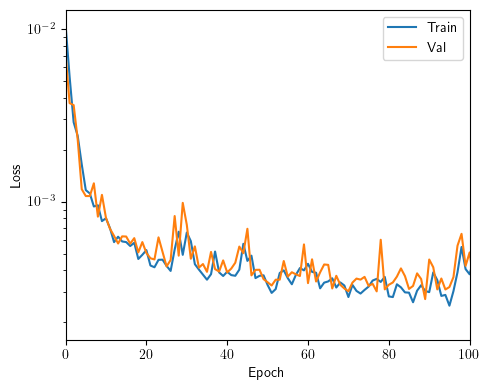

In [13]:

def plot_train_process(train_loss, test_loss, val_accuracy):
    fig, ax = plt.subplots( figsize=(5, 4))

    # ax.set_title('Loss')
    ax.plot(train_loss, label='Train')
    ax.plot(test_loss, label='Val')
    ax.set_yscale('log')

    ax.set_xlim((0, 100))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    fig.tight_layout()

    ax.legend()

plot_train_process(train_loss, test_loss, val_accuracy)

In [14]:
save_checkpoint(checkpoint_path='./models/model_v5', model=model, optimizer=opt)

model saved to ./models/model_v5


In [26]:
# load_checkpoint(checkpoint_path='./models/model_v2', model=model, optimizer=opt)

In [13]:
batch_size = 128

ep_test_accuracy = []
model.train(False) # disable dropout / use averages for batch_norm
with torch.no_grad():
    for X_batch, y_batch, params_batch in get_batches((X_test, y_test, params_test), batch_size):
        # move data to target device
        
        X_batch = X_batch.to(device, torch.float32)
        y_batch = y_batch.to(device, torch.float32)
        # compute predictions
        
        y_pred = model(X_batch)
        print(len(params_batch), len(y_batch))
        ep_test_accuracy.append( np.concatenate( (  
            np.log(np.reshape([acc(y_pred[i], y_batch[i]).item() for i in range(len(y_batch)) ], (-1, 1) ) ), 
                                                  params_batch ), axis=1))

test_mse = np.concatenate(ep_test_accuracy, axis=0)

128 128
70 70


In [33]:
# # test_mse = pd.DataFrame({
# #     'mse': np.random.rand(100),
# #     'time': np.random.rand(100) * 100,
# #     'order': np.random.randint(1, 10, size=100)
# # })

# # Define the number of bins for the histogram
# num_bins = 10

# # Create the histogram for MSE
# counts, bin_edges = np.histogram(test_mse[:, 0], bins=num_bins)

# # Calculate the bin indices for each data point
# bin_indices = np.digitize(test_mse[:, 0], bin_edges)

# # Calculate the mean 'order' and 'time' for each bin
# mean_order = []
# mean_time = []

# for i in range(1, len(bin_edges)):
#     # Get the data points corresponding to the current bin
#     bin_data = test_mse[bin_indices == i]
#     if len(bin_data) > 0:
#         mean_order.append(bin_data[:, 2].mean())
#         mean_time.append(bin_data[:, 1].mean())
#     else:
#         mean_order.append(0)
#         mean_time.append(0)

# # Plotting
# fig, ax1 = plt.subplots( figsize=( 5,2.5), dpi=200)

# # Histogram for MSE
# ax1.hist(test_mse[:, 0], bins=num_bins, alpha=0.7, color='b')
# ax1.set_xlabel('log MSE')
# ax1.set_ylabel('Frequency (log MSE)', color='b')

# # Secondary axis for mean order and time
# ax2 = ax1.twinx()
# ax2.plot(bin_edges[:-1] + 0.5*(bin_edges[1]-bin_edges[0]), mean_order, 'r-', marker='o', label='Mean Order', linewidth=2)
# # ax2.plot(bin_edges[:-1], mean_time, 'g-', marker='x', label='Mean Time', linewidth=2)
# ax2.set_ylabel(r'$\langle n \rangle$', color='red')

# # Add legends and titles
# # fig.suptitle('MSE Histogram with Mean Order and Time')
# # ax2.legend(loc='upper right')
# # plt.savefig('./errors.pdf', dpi=200, bbox_inches='tight')

# plt.show()

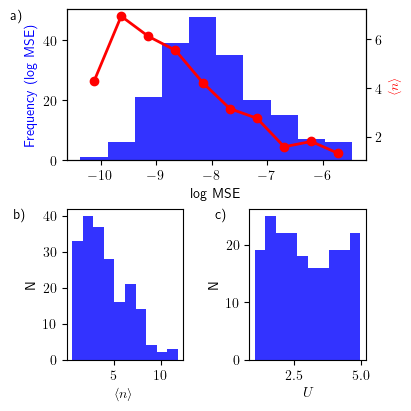

In [32]:

def plot_all():


    fig = plt.figure(constrained_layout=True, figsize=( 4, 4))
    # axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
    #                         gridspec_kw={'width_ratios':[2, 1]})
    
    axs = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']],
                            gridspec_kw={'width_ratios':[1, 1]})
    # axs['Top'].set_title('Spectral function')


    axs['Top'].hist(test_mse[:, 0], bins=num_bins, alpha=0.8, color='b')
    axs['Top'].set_xlabel('log MSE')
    axs['Top'].set_ylabel('Frequency (log MSE)', color='b')

    # Secondary axis for mean order and time
    ax2 = axs['Top'].twinx()
    ax2.plot(bin_edges[:-1] + 0.5*(bin_edges[1]-bin_edges[0]), mean_order, 
                    'r-', marker='o', label='Mean Order', linewidth=2)
    # ax2.plot(bin_edges[:-1], mean_time, 'g-', marker='x', label='Mean Time', linewidth=2)
    ax2.set_ylabel(r'$\langle n \rangle$', color='red')

    # axs['Top'].set_xlim((-1, 1))
    # axs['Top'].set_ylim((0, max(np.max(A0)*1.5,  np.max(A0)*1.5) ))
    # axs['Top'].set_xlabel(r'$E - E_f$(eV)')
    # axs['Top'].set_ylabel('Density of States (DOS)')
    axs['Top'].text(-0.15, 1.0, 'a)', transform=axs['Top'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    # axs['Top'].legend(prop={'size': 10}, frameon=False)  

    # plt.legend()

    #################################################################################################    
    # axs['BottomLeft'].set_title('Plot Top Right')
    axs['BottomLeft'].hist(params_test[:, 1], density=False, alpha=0.8,  color='b')

    axs['BottomLeft'].set_xlabel(r'$\langle n \rangle$')
    axs['BottomLeft'].set_ylabel(r'N')
    # axs['BottomLeft'].set_xlim((0, sample.beta))
    
    axs['BottomLeft'].text(-0.35, 1.0, 'b)', transform=axs['BottomLeft'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    #################################################################################################    
    # axs['BottomRight'].set_title('Legendre')
    axs['BottomRight'].hist(X_test[:, 0], density=False,alpha=0.8,  color='b')
    
    axs['BottomRight'].set_xlabel(r'$U$')
    axs['BottomRight'].set_ylabel('N')
    # axs['BottomRight'].set_xlim((0, 10))
    
    
    axs['BottomRight'].text(-0.2, 1.0, 'c)', transform=axs['BottomRight'].transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')
    
    
    plt.savefig('./dispersion.pdf', dpi=200, bbox_inches='tight')

    plt.show()


plot_all()